In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Optional

$\textbf{Exercise 1: Singular Value Mode Convergence}$

In [0]:
#Define the two matrices:


Sxx = np.eye(4)

Syx = np.zeros((7,4))
Syx[:3] = np.array([[1,1,1,1], [1,1,0,0], [0,0,1,1]])
Syx[3:] = Sxx

$\textbf{Part[a]: Mean weight update equations using Euler forward methods}$

In [0]:
#Euler function:

def euler(f_func, x_0, t_max, dt, eta = .4):
    
    x = x_0
    nsteps = int(t_max / dt)
    
    #A_0 is the SVD of the initial conditions W1_0 and W2_0:
    
    A_0 = np.diag(np.linalg.svd(x_0[1] @ x_0[0])[1])
    
    #The results are stored in an array of shape A_0 x nsteps:
    
    dim1, dim2 = A_0.shape 
    xs = np.zeros((dim1, dim2, nsteps))
    xs[:,:,0] = A_0
    
    i = 1
    t = 0
    
    while i < nsteps:
        
        x = x + eta * f_func(x,t)*dt
        xs[:,:,i] = np.diag(np.linalg.svd(x[1] @ x[0])[1])
        t += dt
        i += 1
    
    return xs

In [0]:
#Define the system of interdependent ODEs as function to feed Euler:

def func(init, t):
    """
    The function defining the system of coupled ODEs
    @params:
    init: the initial conditions of the system
    t: time 
    """
    w1, w2 = init
    
    dw1dt = w2.T @ (Syx - w2 @ w1 @ Sxx)
    dw2dt = (Syx - w2 @ w1 @ Sxx) @ w1.T
    
    #dw_shallow_dt = Syx - w_shallow @ Sxx
    
    return np.array([dw1dt, dw2dt])

def init_cond():
    """
    Returns some initial conditions for testing:
    """
    result = np.array 
    
    return np.array([np.random.normal(0,.01,(16,4)), np.random.normal(0, .01,(7,16))])

$\textbf{Part[b]: Dynamics and Covariance Matrix}$

Text(0, 0.5, 'Error')

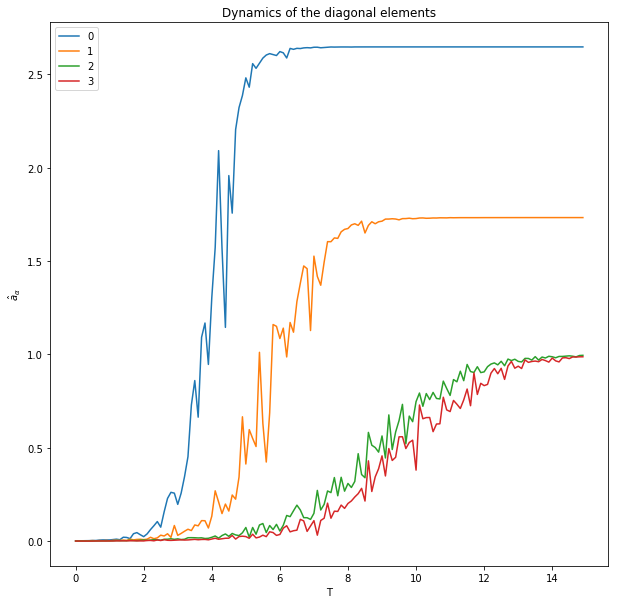

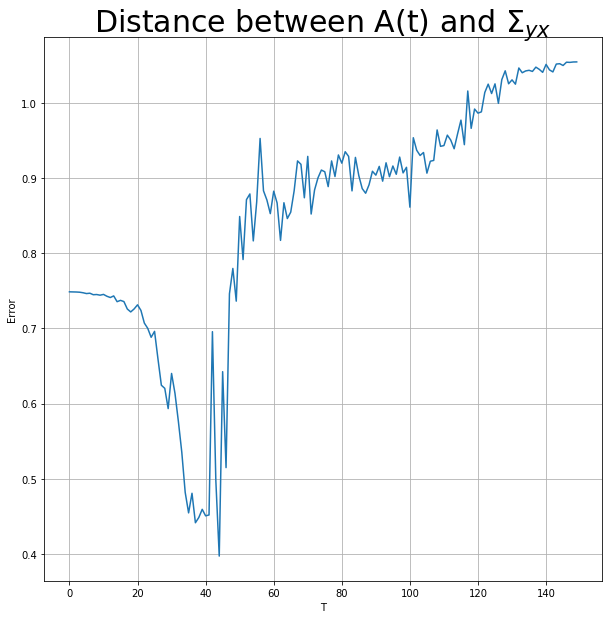

In [0]:
result = np.array([np.diag(euler(func, init_cond(), t_max = 15, dt = .1)[:,:,i]) \
                   for i in range(150)])

#Plot the dynamics of the singular value modes:

plt.figure(figsize = (10,10))

for col in range(4):
    
    plt.plot(np.arange(0,15,.1),result[:,col], label = col)
    plt.title("Dynamics of the diagonal elements")
    plt.grid()
    plt.xlabel("T")
    plt.ylabel(r"$\hat{a}_{\alpha}$")
    plt.legend()
    
#Compute the Euclidean distance between A(t) and [1,1,1,0] = sigma:

plt.figure(figsize = (10,10))

plt.plot(((result - [1,1,1,0])**2).mean(axis = 1)) #Euclidean distance
plt.title("Distance between A(t) and $\Sigma_{yx}$", fontsize = 30)
plt.grid()
plt.xlabel("T")
plt.ylabel("Error")

$\textbf{Part[c]: Analytical Solution}$

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


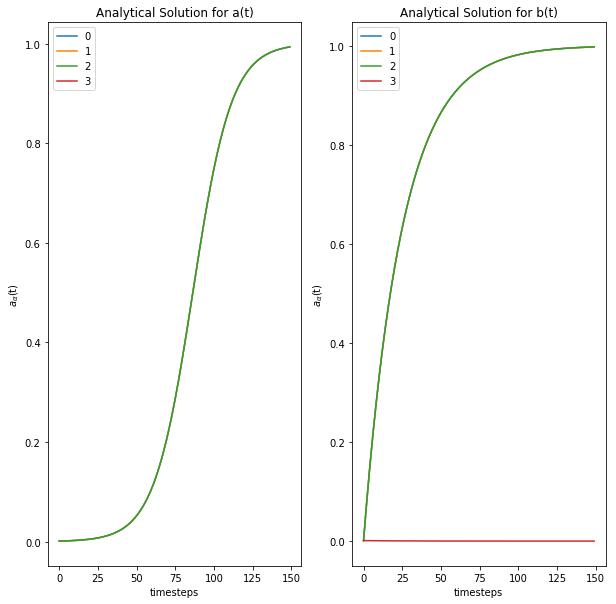

In [0]:
#Define analytical solution for a:

def aanal(sa, t, a0 = .001):
    
    numer = sa * np.exp(2 * sa * .4 * t)
    denom = np.exp(2 * sa * t * .4) - 1 + sa / a0
    
    return numer / denom

aanal_partial = lambda t: aanal(np.array([1,1,1,0]), t)

#Define analytical solution for b:

def banal(sa, t, b0 =.001):
    
    return sa * (1 - np.exp(-0.4 * t)) + b0 * np.exp(-0.4 * t)

banal_partial = lambda t: banal(np.array([1,1,1,0]), t)


def plot_analytical_results():
    
    fig, axs = plt.subplots(1,2, figsize = (10,10), sharex = True)
    
    for col in range(4):
    
        axs[0].plot(np.array(list(map(aanal_partial,np.arange(0,15,.1))))[:,col], \
                   label = col)
        axs[0].set_title("Analytical Solution for a(t)")
        axs[0].set_xlabel("timesteps")
        axs[0].set_ylabel(r"$a_{\alpha}$(t)")
        axs[0].legend()
        
    #axs[0].plot(((result - [1,1,1,0])**2).mean(axis = 1))
        axs[1].plot(np.array(list(map(banal_partial,np.arange(0,15,.1))))[:,col], \
                   label = col)
        axs[1].set_title("Analytical Solution for b(t)")
        axs[1].set_xlabel("timesteps")
        axs[1].set_ylabel(r"$a_{\alpha}$(t)")
        axs[1].legend()
    

plot_analytical_results()

[((0,), 1), ((1,), 2), ((2,), 3)]

# Models of Higher Brain Functions - Computer Practical
## 'Learning Dynamics in Deep Linear Networks' - November 2019 - TU Berlin

# Skeleton for Exercise Two:  Deeper (Non-)Linear Networks with AutoDiff

$\textbf{Andrey Em}$ \
$\textbf{Leonard Hollander}$

Install PyTorch, for example with conda:
```
conda install pytorch
```
or with pip:
```
pip install torch
```

In [0]:
# Import the required packages
import numpy as np
from numpy.linalg import svd as svd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

np.random.seed(1)

# A. Branching Diffusion Process for Data Generation

The `DiffuseTreeSampler`Class implements a hierarchical data-generation process which we use throughout this exercise (**no need to implement anything from scratch**). A target is generated for all datapoints at a time in a tree-based sequential fashion. A first +/-1 coin flip determines the initial sign of the node at the top of the tree. Afterwards, the tree branches and changes the sign at each stage with a small probability. We repeat this branching process for each layer of the tree. The bottom of the tree corresponds to the value of one feature across the different datapoints. In order to generate multiple target dimensions, the process is repeated for each dimension independently. Finally, we stack them into the overall targets. The input again corresponds to the identity matrix. For more information you can have a look here: https://arxiv.org/pdf/1810.10531.pdf (p. 14). 

In [0]:
class DiffuseTreeSampler():
    def __init__(self, target_dim, tree_depth, branching_factor, sample_epsilon):
        self.target_dim = target_dim
        self.num_examples = branching_factor**tree_depth
        self.tree_depth = tree_depth
        self.branching_factor = branching_factor
        self.sample_epsilon = sample_epsilon
    
    def sample_target(self):
        samples_per_tree_layer = [self.branching_factor**i for i in range(1, self.tree_depth+1)] 
        target_tree = [np.random.choice([-1, 1], p=[0.5, 0.5], size=1)]
        for l in range(self.tree_depth):
            switch = np.random.choice([-1, 1],
                                      p=[self.sample_epsilon, 1-self.sample_epsilon],
                                      size=samples_per_tree_layer[l])
            next_layer = np.repeat(target_tree[-1], self.branching_factor)
            target_tree.append(next_layer*switch)
        return target_tree[-1]
    
    def sample_data(self):
        """
        Each target dimension diffuses independently of the others!
        """
        targets = []
        for tar in range(self.target_dim):
            target_temp = self.sample_target()
            targets.append(target_temp)
        
        targets_out = np.array(targets).T
        features_out = np.diag(np.ones(self.num_examples))
        return targets_out, features_out

In [0]:
# Create the dataset by instantiating and sampling
hierarchical_tree = DiffuseTreeSampler(target_dim=100, tree_depth=3,
                                       branching_factor=4, sample_epsilon=0.5)

targets, features = hierarchical_tree.sample_data()

print("Output Dimensions: {}".format(targets.shape))
print("Input Dimensions: {}".format(features.shape))

Output Dimensions: (64, 100)
Input Dimensions: (64, 64)


In [0]:
# Calculate the SVD of the covariance matrix
SIGMA_YX = targets.T @ features
U, s, V = svd(SIGMA_YX, full_matrices=True)

# B. PyTorch Example - Feedforward Networks
* Define Neural Network Architecture (single hidden layer ReLU activation)
* Create a Network Instance, Optimizer (stochastic gradient descent) & MSE (mean squared error) Loss
* Perform a forward pass to get predictions, calculate the loss
* Reset the gradients to 0 and perform a backward pass to calculate the gradients + (SGD) update

In [0]:
# Example Feedforward PyTorch Network
class DeepNet(nn.Module):
    """
    Deep Network in PyTorch - Single Hidden Layer with ReLU activation
    Inputs: Input Array Dimensions, Output Array Dimensions
    """
    def __init__(self, input_dim, output_dim):
        super(DeepNet, self).__init__()
        # Define a dictionary that collects the different layers 
        # Afterwards, this dictionary provides the input to the nn.Sequential model
        layers = OrderedDict()
        layers["in_hidden"] = nn.Linear(input_dim, 64, bias=False)
        layers["in_hidden-activation"] = nn.ReLU()
        layers["hidden_out"] = nn.Linear(64, output_dim, bias=False)
        self.model = nn.Sequential(layers)
        
    def forward(self, input_array):
        # Propagate the input through the linear network
        return self.model(input_array.float())

In [0]:
# Create the network instance, define the learning rate, optimizer & loss
input_dim, output_dim = features.shape[1], targets.shape[1]

l_rate = 0.5
relu_net = DeepNet(input_dim, output_dim)
relu_optimizer = optim.SGD(relu_net.parameters(), lr=l_rate)

mse_loss = nn.MSELoss()

print("The Network Architecture")
print(relu_net)

The Network Architecture
DeepNet(
  (model): Sequential(
    (in_hidden): Linear(in_features=64, out_features=64, bias=False)
    (in_hidden-activation): ReLU()
    (hidden_out): Linear(in_features=64, out_features=100, bias=False)
  )
)


In [0]:
# Perform a forward pass through the network and calculate the loss
input_tensor = torch.tensor(features[0])
y_true = torch.tensor(targets[0]).float()
y_hat = relu_net(input_tensor)
loss = mse_loss(y_hat, y_true)

print("The MSE Loss for the 1st datapoint:{:.3f}".format(loss))  

The MSE Loss for the 1st datapoint:1.010


In [0]:
# Perform a backward pass and update the weights using the SGD optimizer
relu_net.zero_grad()
print("Gradient Sum Input-Hidden Weights after reset: {}".format(relu_net.model.in_hidden.weight.grad))
loss.backward()
print("Gradient Sum Input-Hidden Weights after backward pass: {}".format(relu_net.model.in_hidden.weight.grad.sum()))
relu_optimizer.step()

Gradient Sum Input-Hidden Weights after reset: None
Gradient Sum Input-Hidden Weights after backward pass: 0.12680968642234802


# 1. Code a Variable Depth Linear Network

In [0]:
# TODO: Generalize to variable depth
class DeepLinearNet(nn.Module):
    """
    Deep Network in PyTorch - Single Hidden Layer with ReLU activation
    Inputs: Input Array Dimensions, Output Array Dimensions
    """
    def __init__(self, input_dim=64, output_dim=100, hidden_units = [64]):
        super(DeepLinearNet, self).__init__()
        # Define a dictionary that collects the different layers 
        # Afterwards, this dictionary provides the input to the nn.Sequential model
        layers = OrderedDict()
        
        input_dim_layer = input_dim
        
        for hidI, hid in np.ndenumerate(hidden_units):
            
            layers["in-hidden " + str(hidI[0])] = \
            nn.Linear(input_dim_layer, hidden_units[hidI[0]], bias=False)
            
            input_dim_layer = hidden_units[hidI[0]]
    
        layers["hidden-out"] = nn.Linear(hidden_units[-1], output_dim, bias=False)
        self.model = nn.Sequential(layers)
        
    def forward(self, input_array):
        # Propagate the input through the linear network
        return self.model(input_array.float())

# 2. Code the Learning Loop for the Linear Network

In [0]:
# TODO: Define the Online Gradient Descent Training Loop
def linear_net_learning(deep_net, mse_loss, optimizer, num_epochs, features, targets):
    """
    Inputs: 'deep_net'   - Instantiated PyTorch Network
            'mse_loss'   - Loss Criterion, i.e. Mean Squared Error
            'optimizer'  - PyTorch Optimizer Object, i.e. Stochastic Gradient Descent
            'num_epochs' - Number of Training Loops over the entire dataset
            'features'   - Training features generated from the sampler
            'targets'    - Training targets generated from the sampler
    Function: Runs the learning loop for the linear network
    """
    
    deep_optimizer = optim.SGD(deep_net.parameters(), lr= .5)
    
    loss_log = []
    log_singular_vals = []
    num_points = targets.shape[0]
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        # Reshuffle the order of the dataset
        
        data = list(zip(features, targets))
        np.random.shuffle(data)
        features, targets = zip(*data)
        
        # Loop over all examples in an Online SGD Loop
        for t in range(num_points):
            # Extract the current training datapoint and transform it into a Torch Tensor
            input_tensor = torch.tensor(features[t])
            y_true = torch.tensor(targets[t]).float()
                
            # Compute the prediction for the single datapoint y^hat & the corresponding loss
            
            y_hat = deep_net(input_tensor)
            loss = mse_loss(y_hat, y_true)
            
            #Clear the gradients, Perform the backward pass, and SGD update
            
            deep_net.zero_grad() 
            loss.backward()
            deep_optimizer.step()
            
            # Update the epoch loss tracker
            epoch_loss += loss.item()
            
        # Log the mean epoch loss & calculate the SVD
        loss_log.append(epoch_loss/num_points)  
        y_hat_full = deep_net(torch.tensor(features)).detach().numpy()
        U, s, V = svd(y_hat_full.T, full_matrices=True)
        log_singular_vals.append(s)
    return loss_log, np.array(log_singular_vals)

# 3. Run the Loop & Plot the singular values

In [0]:
# TODO: Instantiate the network, define the loss & optimizer and run the learning loop

#Generate a training set:

data_set = DiffuseTreeSampler(target_dim = 100,\
                              tree_depth = 3, \
                              branching_factor = 4, \
                              sample_epsilon = .5)

targets2, features2 = data_set.sample_data()

# Calculate the SVD of the covariance matrix
Syx = targets2.T @ features2
U2, s2, V2 = svd(Syx, full_matrices=True)

print("The singular value decomposition of the training data is:")
#print(s2)

assert np.all((features2.T @ features2) == np.eye(features2.shape[1]))

The singular value decomposition of the training data is:


In [0]:
#Instantiating the deep linear network:

input_dim, output_dim = features.shape[1], targets.shape[1]

deepNet = DeepLinearNet(input_dim, output_dim, hidden_units = [64, 128, 128])
deepNet_optimizer = optim.SGD(deepNet.parameters(), lr= .5)

mse_loss = nn.MSELoss()

print("The Network Architecture")
print(deepNet)


#Running the learning loop:

svals = linear_net_learning(deepNet, \
                            mse_loss, \
                            deepNet_optimizer, \
                            1000, \
                            features2, \
                            targets2)[1]




The Network Architecture
DeepLinearNet(
  (model): Sequential(
    (in-hidden 0): Linear(in_features=64, out_features=64, bias=False)
    (in-hidden 1): Linear(in_features=64, out_features=128, bias=False)
    (in-hidden 2): Linear(in_features=128, out_features=128, bias=False)
    (hidden-out): Linear(in_features=128, out_features=100, bias=False)
  )
)


[[3.9310592e-01 3.7359595e-01 3.2735628e-01 ... 2.7004867e-03
  1.3951962e-03 4.9731438e-04]
 [4.6911010e-01 4.4399238e-01 3.6051992e-01 ... 2.8505418e-03
  1.2764509e-03 5.4825202e-04]
 [6.1043978e-01 5.7105184e-01 4.6913403e-01 ... 2.8075844e-03
  1.1662676e-03 5.6305563e-04]
 ...
 [1.7287987e+01 1.6461334e+01 1.6148979e+01 ... 3.0357957e+00
  2.7494743e+00 1.0575452e-02]
 [1.7268696e+01 1.6447271e+01 1.6103771e+01 ... 3.0356863e+00
  2.7495313e+00 1.0642533e-02]
 [1.7284018e+01 1.6448244e+01 1.6148046e+01 ... 3.0357435e+00
  2.7494781e+00 1.0703669e-02]]


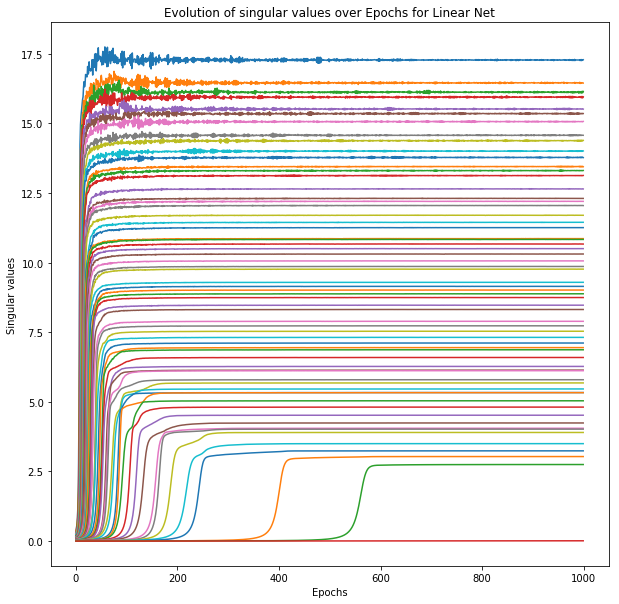

In [0]:
print(svals)
# Plot the singular values

import matplotlib.pyplot as plt

def plot_svals(svals, header):
    
    plt.figure(figsize = (10,10))
    
    for sval in svals.T:
        
        plt.plot(sval)
        plt.title("Evolution of singular values over Epochs for {} Net".format(header))
        plt.xlabel("Epochs")
        plt.ylabel("Singular values")

plot_svals(svals = svals, header = "Linear")


# 4. Add ReLU Non-Linearities to the Architecture & Repeat

In [0]:
# Define a new network class that adds a ReLU activation function after each layer.

class DeepNetRelu(nn.Module):
    """
    Deep Network in PyTorch - Single Hidden Layer with ReLU activation
    Inputs: Input Array Dimensions, Output Array Dimensions
    """
    def __init__(self, input_dim=64, output_dim=100, hidden_units = [64]):
        super(DeepNetRelu, self).__init__()
        # Define a dictionary that collects the different layers 
        # Afterwards, this dictionary provides the input to the nn.Sequential model
        layers = OrderedDict()
        
        input_dim_layer = input_dim
        
        for hidI, hid in np.ndenumerate(hidden_units):
            
            layers["in-hidden " + str(hidI[0])] = \
            nn.Linear(input_dim_layer, hidden_units[hidI[0]], bias=False)
            
            layers["in-hidden " + str(hidI[0]) +"-activation"] = nn.ReLU()
            
            input_dim_layer = hidden_units[hidI[0]]
    
        layers["hidden-out"] = nn.Linear(hidden_units[-1], output_dim, bias=False)
        self.model = nn.Sequential(layers)
        
    def forward(self, input_array):
        # Propagate the input through the linear network
        return self.model(input_array.float())

In [0]:
# TODO: Instantiate the network, define the loss & optimizer and run the learning loop

input_dim, output_dim = features.shape[1], targets.shape[1]

deepReluNet = DeepNetRelu(input_dim, output_dim, hidden_units = [64, 128, 128])
deepReluNet_optimizer = optim.SGD(deepReluNet.parameters(), lr= .5)

mse_loss = nn.MSELoss()

print(deepReluNet)

DeepNetRelu(
  (model): Sequential(
    (in-hidden 0): Linear(in_features=64, out_features=64, bias=False)
    (in-hidden 0-activation): ReLU()
    (in-hidden 1): Linear(in_features=64, out_features=128, bias=False)
    (in-hidden 1-activation): ReLU()
    (in-hidden 2): Linear(in_features=128, out_features=128, bias=False)
    (in-hidden 2-activation): ReLU()
    (hidden-out): Linear(in_features=128, out_features=100, bias=False)
  )
)


In [0]:
svals_relu = linear_net_learning(deepReluNet, \
                            mse_loss, \
                            deepReluNet_optimizer, \
                            1000, \
                            features2, \
                            targets2)[1]

print(svals_relu)



# TODO: Plot the singular values

[[1.1049306e+01 3.0791596e-01 2.3769049e-01 ... 7.6190184e-04
  4.1957479e-04 3.5102988e-04]
 [1.0191024e+01 3.2479101e-01 2.4246134e-01 ... 9.3046628e-04
  4.4330306e-04 3.9388231e-04]
 [1.0627102e+01 3.6067873e-01 2.5916165e-01 ... 9.9669979e-04
  6.4461475e-04 4.6739308e-04]
 ...
 [1.7277533e+01 1.6456923e+01 1.6121710e+01 ... 3.0364137e+00
  2.7502565e+00 2.4038701e+00]
 [1.7277533e+01 1.6456921e+01 1.6121710e+01 ... 3.0364137e+00
  2.7502568e+00 2.4038703e+00]
 [1.7277533e+01 1.6456923e+01 1.6121710e+01 ... 3.0364134e+00
  2.7502568e+00 2.4038703e+00]]


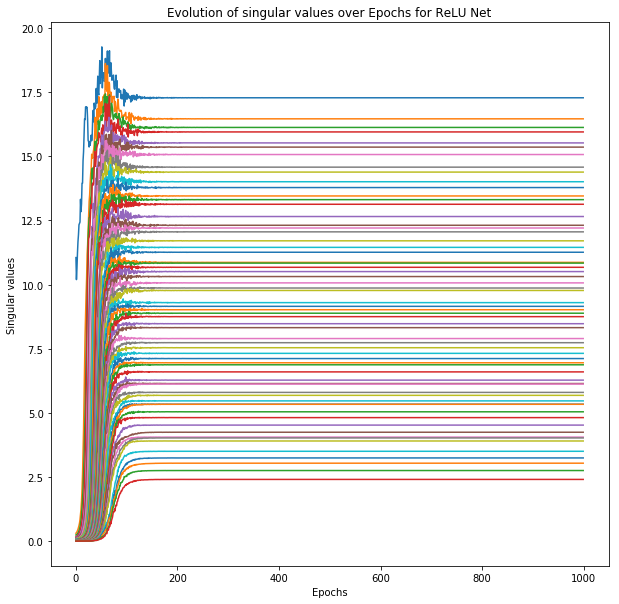

In [0]:
plot_svals(svals_relu, header = "ReLU")

When we compare the two plots we can therefore see that the ReLU net converges much faster. We can also see that the weights all converge at the same time.